# <centre>Image Captioning with Vision-Text Models: Training both encoder and decoder </centre>
**Vision Encoder-Decoder Model** for generating captions for images. We'll use the Flickr8k dataset. Available at <a href = "https://www.kaggle.com/datasets/adityajn105/flickr8k">kaggle/flick8k</a>

In [ ]:
# Imports
import os
import torch
import datasets
import evaluate
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (VisionEncoderDecoderModel, AutoTokenizer, 
                          ViTFeatureExtractor)


os.environ["WANDB_DISABLED"] = "true"

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

In [ ]:
# Load the captions dataset
data_path = "flickr8k/captions.txt"
image_dir = "flickr8k/Images"

# Read and split data
ds = pd.read_csv(data_path)
train_ds, eval_ds = train_test_split(ds, test_size=0.2, random_state=42)

print("Sample data:")
print(ds.head())

# Convert to Hugging Face Dataset
train_dataset = datasets.Dataset.from_pandas(train_ds)
eval_dataset = datasets.Dataset.from_pandas(eval_ds)

Sample data:
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


In [ ]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataframe, tokenizer, feature_extractor, max_target_length=128, image_dir="flickr8k/Images", check_image=True):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_target_length = max_target_length
        self.image_dir = image_dir
        self.check_image = check_image

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get a row from the dataset
        data = self.dataframe.iloc[idx]
        image_path = data['image']
        caption = data['caption']

        # Preprocess the image
        img = Image.open(os.path.join(self.image_dir, image_path))
        pixel_values = self.feature_extractor(images=img, return_tensors="pt").pixel_values.squeeze(0)

        # Preprocess the caption (tokenization)
        labels = self.tokenizer(caption, padding="max_length", max_length=self.max_target_length).input_ids

        # Handle special cases in tokenization (padding)
        if len(labels) < self.max_target_length:
            labels.extend([self.tokenizer.pad_token_id] * (self.max_target_length - len(labels)))
            
        # Return the prepared data
        return {
            'pixel_values': pixel_values,
            'labels': torch.tensor(labels)
        }

In [ ]:
# Model Configurations
image_encoder_model = "google/vit-base-patch16-224-in21k"
text_decoder_model = "gpt2"

# Load feature extractor and tokenizer
feature_extractor = ViTFeatureExtractor.from_pretrained(image_encoder_model)
tokenizer = AutoTokenizer.from_pretrained(text_decoder_model)
tokenizer.pad_token = tokenizer.eos_token 

# Initialize the Vision-Encoder-Decoder model
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    image_encoder_model, text_decoder_model, trust_remote_code=True
)
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

/Users/sankalpa/Desktop/Machine Learning/venv/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.we

# Freeze or Not the Encoder part of the model

In [ ]:
freeze_encoder = False

In [ ]:
# Freeze the encoder part weights
if freeze_encoder:
    for param in model.encoder.parameters():
        param.requires_grad = False

    print("Encoder weights frozen.")

In [6]:
def collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    print(f"Pixel values shape: {pixel_values.shape}")
    print(f"Labels shape: {labels.shape}")
    return {
        'pixel_values': pixel_values,
        'labels': labels
    }

In [7]:
# Create training and evaluation datasets using the custom class
train_dataset = ImageCaptioningDataset(train_ds, tokenizer, feature_extractor, max_target_length=128, image_dir=image_dir)
eval_dataset = ImageCaptioningDataset(eval_ds, tokenizer, feature_extractor, max_target_length=128, image_dir=image_dir)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4, shuffle=False)

In [ ]:
# Calculate ROUGE score
rouge = evaluate.load('rouge')

def compute_metrics(preds, labels):
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    return result

In [ ]:
# Optimizer and Loss
optimizer = AdamW(model.parameters(), lr=5e-5)
#loss_fn = compute_metrics()

model = torch.nn.DataParallel(model)
model.to(device)

train_losses = []
eval_losses = []
rogue_scores = []

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_dataloader):
        torch.cuda.empty_cache()
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(pixel_values=pixel_values, labels=labels)

        #logits = outputs.logits

        # Compute loss
        loss = outputs.loss

        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss}")

    # Optionally evaluate the model
    model.eval()
    total_eval_loss = 0.0
    rogue_batch = {'rouge1': [], 'rouge2': [], 'rougeL': [], 'rougeLsum': []} # ROUGELSum is not necessary, it is for multiple sentences.
    for batch in tqdm(eval_dataloader):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(pixel_values=pixel_values, labels=labels)
            logits = torch.argmax(outputs.logits, dim=-1)

            loss = outputs.loss
            total_eval_loss += loss.item()
            score = compute_metrics(logits, labels)
            
            for metric in score:
                rogue_batch[metric].append(score[metric])
        
    average_scores = {metric: sum(scores) / len(scores) for metric, scores in rogue_batch.items()}
    eval_loss = total_eval_loss / len(eval_dataloader)

    eval_losses.append(eval_loss)
    rogue_scores.append(average_scores)

    print(f"Validation Loss: {eval_loss}")
    print(f"Validation ROUGE:")

    df_scores = pd.DataFrame(average_scores, index=[0])
    print(df_scores)
    # Save the best model
    if epoch == 0 or total_eval_loss < best_eval_loss:
        best_eval_loss = total_eval_loss
        model.module.save_pretrained("best_model")
        tokenizer.save_pretrained("best_model")

100%|██████████| 8091/8091 [40:14<00:00,  3.35it/s]


Epoch 1/5, Loss: 0.26610261843413274


100%|██████████| 2023/2023 [08:15<00:00,  4.08it/s]


Validation Loss: 0.23583826855068094
Validation ROUGE:
     rouge1    rouge2    rougeL  rougeLsum
0  0.462951  0.173113  0.443605   0.443616


100%|██████████| 8091/8091 [39:05<00:00,  3.45it/s]


Epoch 2/5, Loss: 0.21534098027210244


100%|██████████| 2023/2023 [08:10<00:00,  4.12it/s]


Validation Loss: 0.22371300545236114
Validation ROUGE:
     rouge1    rouge2    rougeL  rougeLsum
0  0.486967  0.196766  0.468601   0.468581


100%|██████████| 8091/8091 [39:35<00:00,  3.41it/s]


Epoch 3/5, Loss: 0.1872913205160256


100%|██████████| 2023/2023 [08:24<00:00,  4.01it/s]


Validation Loss: 0.21964410006690602
Validation ROUGE:
     rouge1    rouge2    rougeL  rougeLsum
0  0.498414  0.210473  0.479827   0.479832


100%|██████████| 8091/8091 [39:16<00:00,  3.43it/s]


Epoch 4/5, Loss: 0.1639563065147005


100%|██████████| 2023/2023 [08:19<00:00,  4.05it/s]


Validation Loss: 0.2214260428731417
Validation ROUGE:
     rouge1    rouge2    rougeL  rougeLsum
0  0.506135  0.219755  0.487566   0.487578


100%|██████████| 8091/8091 [39:12<00:00,  3.44it/s]


Epoch 5/5, Loss: 0.1438215263026737


100%|██████████| 2023/2023 [08:22<00:00,  4.03it/s]

Validation Loss: 0.2288922565964797
Validation ROUGE:
    rouge1    rouge2    rougeL  rougeLsum
0  0.50493  0.218409  0.485426   0.485437


In [11]:
model.module.save_pretrained("final_model")
tokenizer.save_pretrained("final_model")

('final_model/tokenizer_config.json',
 'final_model/special_tokens_map.json',
 'final_model/vocab.json',
 'final_model/merges.txt',
 'final_model/added_tokens.json',
 'final_model/tokenizer.json')

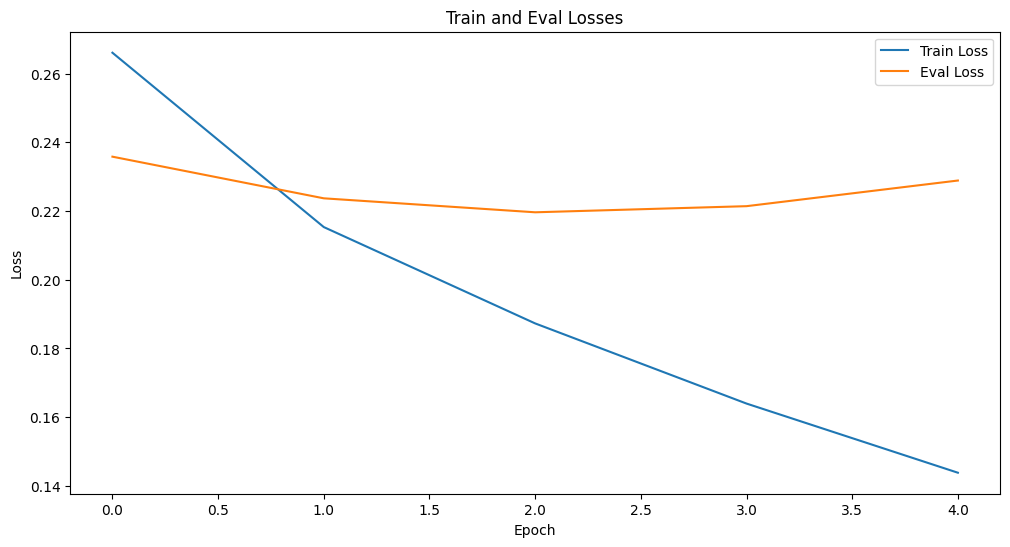

<Figure size 640x480 with 0 Axes>

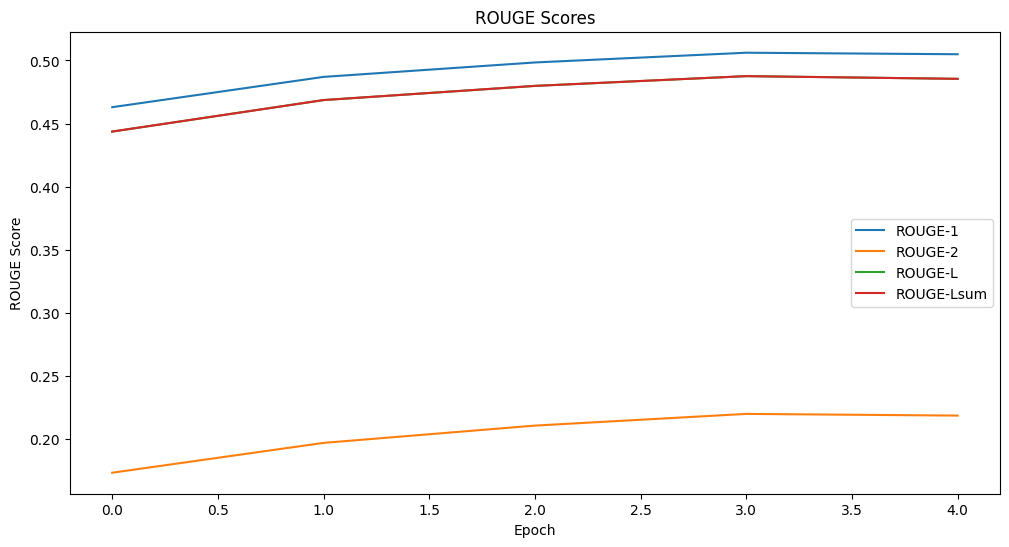

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt

# Plot train and eval losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Eval Losses')
plt.legend()
plt.show()
plt.savefig('train_eval_losses.png')

# Plot ROUGE scores
rouge1_scores = [score['rouge1'] for score in rogue_scores]
rouge2_scores = [score['rouge2'] for score in rogue_scores]
rougeL_scores = [score['rougeL'] for score in rogue_scores]
rougeLsum_scores = [score['rougeLsum'] for score in rogue_scores]

plt.figure(figsize=(12, 6))
plt.plot(rouge1_scores, label='ROUGE-1')
plt.plot(rouge2_scores, label='ROUGE-2')
plt.plot(rougeL_scores, label='ROUGE-L')
plt.plot(rougeLsum_scores, label='ROUGE-Lsum')
plt.xlabel('Epoch')
plt.ylabel('ROUGE Score')
plt.title('ROUGE Scores')
plt.legend()
plt.show()
plt.savefig('rouge_scores.png')

# Results with fine tuning of decoder alone

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0

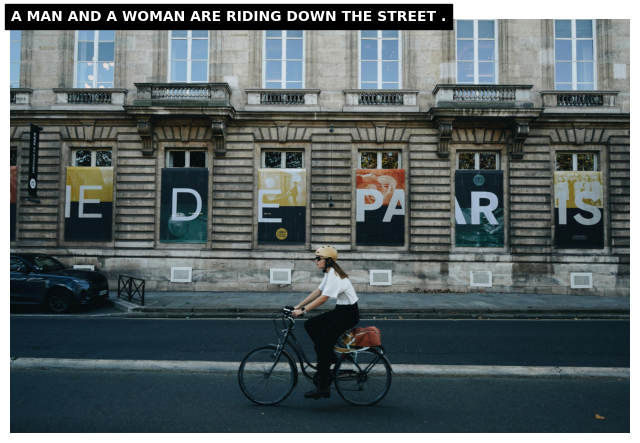

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


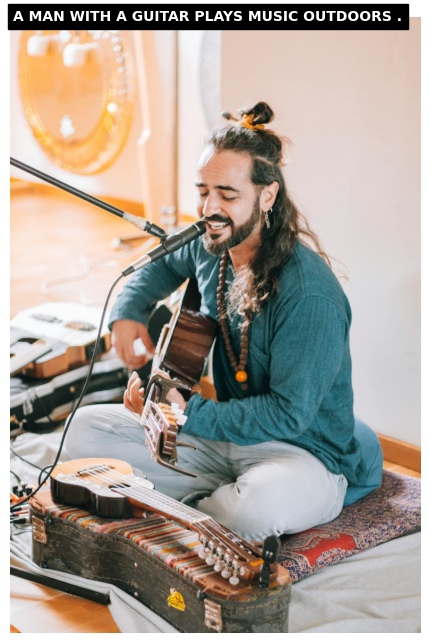

In [4]:
# Load the best model and tokenizer
best_model = VisionEncoderDecoderModel.from_pretrained("results_decoder/final_model")
best_tokenizer = AutoTokenizer.from_pretrained("results_decoder/final_model")
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Move the model to the appropriate device
best_model.to(device)

# Function to generate caption for an image
def generate_caption(image_path, model, tokenizer, feature_extractor, max_length=128):
    # Preprocess the image
    img = Image.open(image_path)
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)

    # Generate caption
    model.eval()
    with torch.no_grad():
        output_ids = model.generate(pixel_values, max_length=max_length, num_beams=4, early_stopping=True)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    # Write caption on the image with white bold capitalized characters
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.text(8, 8, caption.upper(), fontsize=10, color='white', weight='bold', backgroundcolor='black')
    plt.axis('off')
    plt.show()

# Example usage
image_path = "random.jpg"
generate_caption(image_path, best_model, best_tokenizer, feature_extractor)

image_path = "new.jpg"
generate_caption(image_path, best_model, best_tokenizer, feature_extractor)

# Results with both encoder and decoder fine tuned

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0

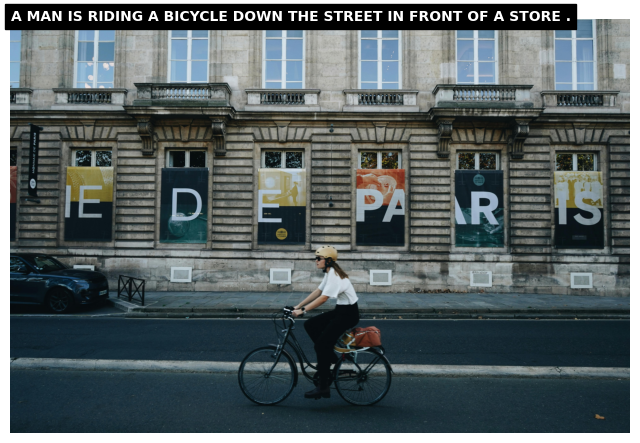

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


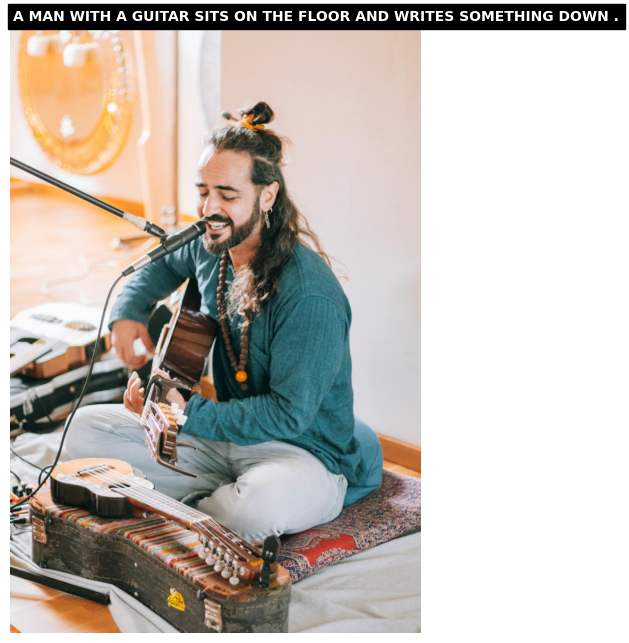

In [ ]:
# Load the best model and tokenizer
best_model = VisionEncoderDecoderModel.from_pretrained("results_both/final_model")
best_tokenizer = AutoTokenizer.from_pretrained("results_both/final_model")
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Move the model to the appropriate device
best_model.to(device)

# Function to generate caption for an image
def generate_caption(image_path, model, tokenizer, feature_extractor, max_length=128):
    # Preprocess the image
    img = Image.open(image_path)
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)

    # Generate caption
    model.eval()
    with torch.no_grad():
        output_ids = model.generate(pixel_values, max_length=max_length, num_beams=4, early_stopping=True)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    # Write caption on the image with white bold capitalized characters
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.text(8, 8, caption.upper(), fontsize=10, color='white', weight='bold', backgroundcolor='black')
    plt.axis('off')
    plt.show()

# Example usage
image_path = "random.jpg"
generate_caption(image_path, best_model, best_tokenizer, feature_extractor)

image_path = "new.jpg"
generate_caption(image_path, best_model, best_tokenizer, feature_extractor)